In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Caminho das pastas
train = '/content/drive/MyDrive/RV/Projeto/train'
val = '/content/drive/MyDrive/RV/Projeto/val'
test = '/content/drive/MyDrive/RV/Projeto/test'

# Geradores de dados para carregamento das imagens
datagen_treino = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen_val = ImageDataGenerator(rescale=1.0/255)
datagen_teste = ImageDataGenerator(rescale=1.0/255)

# Dados de treinamento
treino_generator = datagen_treino.flow_from_directory(
    train,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=True  # Isso evita repetição de dados em batches consecutivos
)

# Dados de validação
val_generator = datagen_val.flow_from_directory(
    val,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Para manter os dados consistentes durante a validação
)

# Dados de teste
teste_generator = datagen_teste.flow_from_directory(
    test,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)


Mounted at /content/drive
Found 5236 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Classes: {'NORMAL': 0, 'PNEUMONIA': 1}
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
164/164 ━━━━━━━━━━━━━━━━━━━━ 692s 4s/step - accuracy: 0.9096 - loss: 0.2220 - precision: 0.9257 - val_accuracy: 0.8125 - val_loss: 0.3695 - val_precision: 0.7273
Epoch 2/5
164/164 ━━━━━━━━━━━━━━━━━━━━ 341s 2s/step - accuracy: 0.9519 - loss: 0.1173 - precision: 0.9677 - val_accuracy: 0.8125 - val_loss: 0.4021 - val_precision: 0.7273
Epoch 3/5
164/164 ━━━━━━━━━━━━━━━━━━━━ 340s 2s/step - accuracy: 0.9503 - loss: 0.1249 - precision: 0.9690 - val_accuracy: 0.8125 - val_loss: 0.3368 - val_precision: 0.7778
Epoch 4/5
164/164 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - accuracy: 0.9635 - loss: 0.1055 - precision: 0.9758 - val_accuracy: 0.8125 - val_loss: 0.4688 - val_precision: 0.7778
Epoch 5/5
164/164 ━━━━━━━━━━━━━━━━━━━━ 334s 2s/step - accuracy: 0.9540 - loss: 0.1021 - precision: 0.9710 - val_accuracy: 0.8750 - val_loss: 0.3204 - val_precision: 0.8750
20/20 ━━━━━━━━━━━━━━━━━━━━ 199s 10s/step - accuracy: 0.8886 - loss: 0.2817 - precision: 0.5443
Test Loss: 0.2666
Test Accuracy: 0.8990
Test 

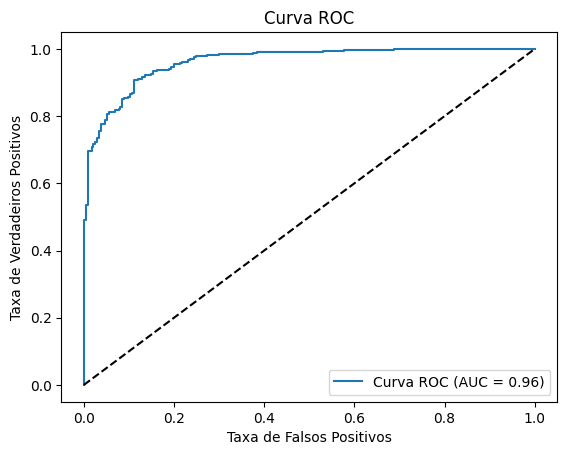

Última camada convolucional: Conv_1
Mapping de classes: {'NORMAL': 0, 'PNEUMONIA': 1}
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


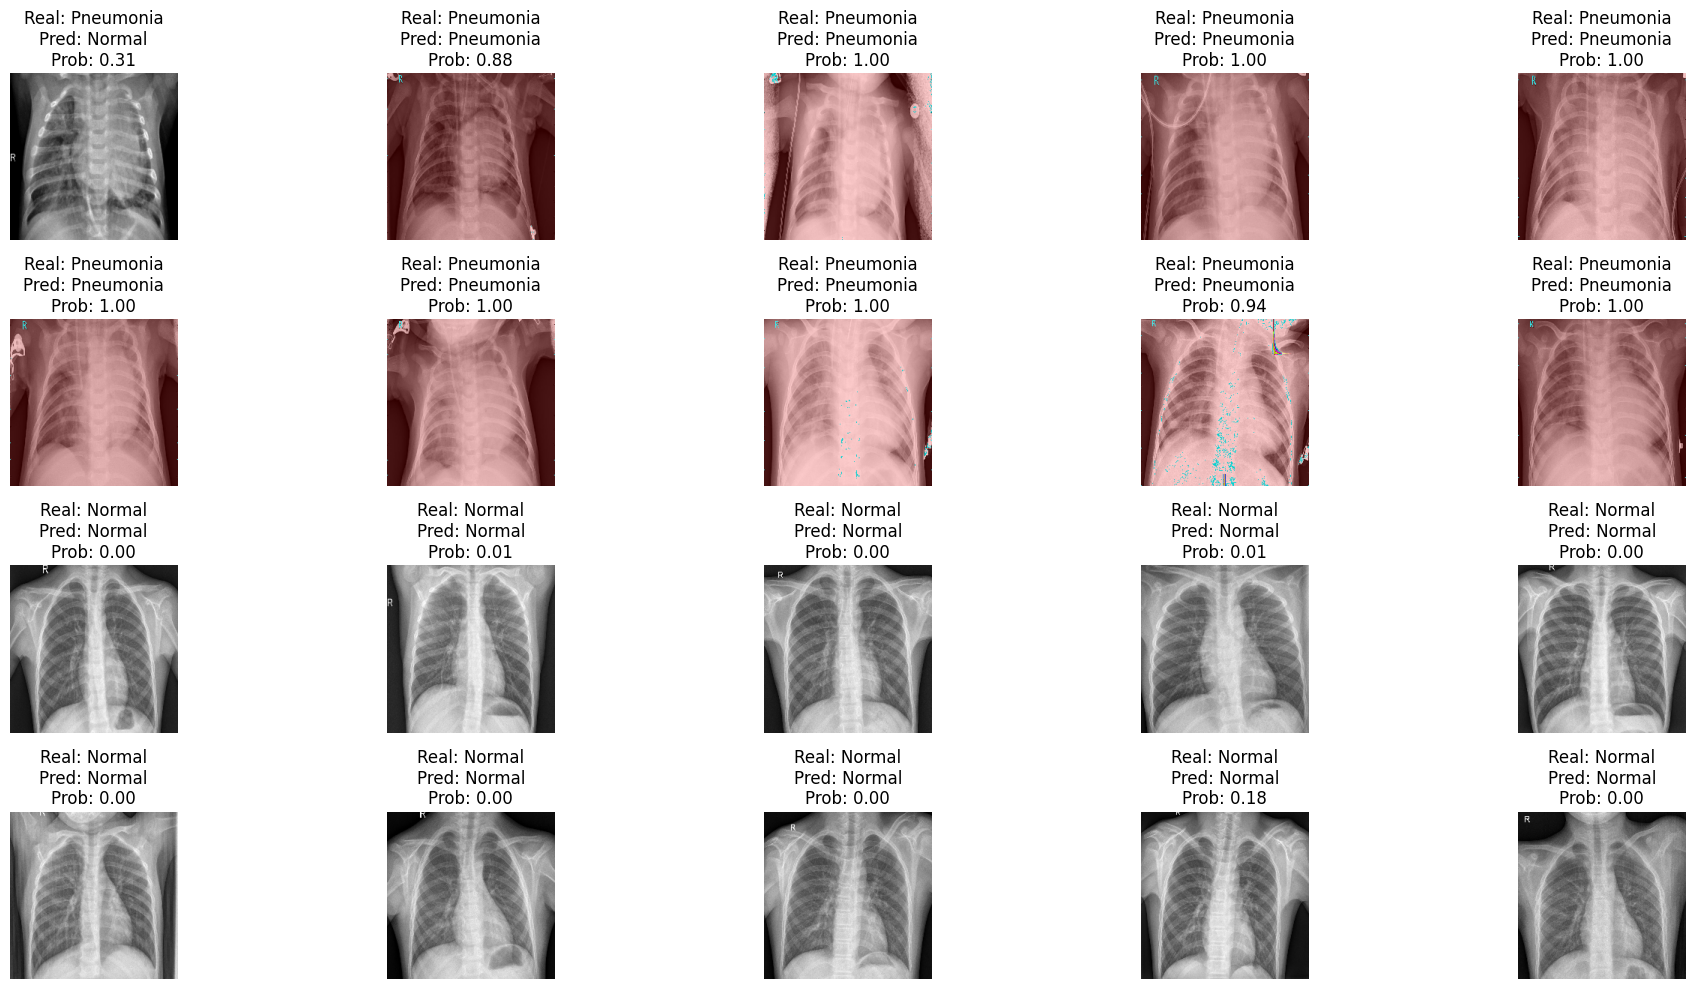

In [ ]:
# Monta o drive (já que os dados estão no Google Drive)
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import roc_curve, auc

# Caminhos das pastas
train_dir = '/content/drive/MyDrive/RV/Projeto/train'
val_dir   = '/content/drive/MyDrive/RV/Projeto/val'
test_dir  = '/content/drive/MyDrive/RV/Projeto/test'

# Parâmetros de pré-processamento
image_size = (224, 224)
batch_size = 32

# Geradores de dados
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # para que possamos relacionar as predições com os rótulos
)

# Exibe o mapeamento das classes
print("Classes:", train_generator.class_indices)

#############################################
# Criação do modelo com MobileNetV2 pré-treinado
#############################################

# Carrega o MobileNetV2 sem a camada final (include_top=False)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(image_size[0], image_size[1], 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # congela as camadas do base_model

# Cria o classificador
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision()])

model.summary()

#############################################
# Treinamento do modelo
#############################################

epochs = 5  # ajuste conforme necessário
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

#############################################
# Avaliação no conjunto de teste e métricas
#############################################

test_loss, test_acc, test_precision = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")

# Predições no conjunto de teste (atenção: usamos o test_generator sem shuffle)
test_generator.reset()
preds = model.predict(test_generator)
# Como usamos ativação sigmoid, convertemos para rótulo 0 ou 1 com threshold 0.5
preds_binary = (preds > 0.5).astype(int).reshape(-1)
true_labels = test_generator.classes

#############################################
# Cálculo e Plot da Curva ROC
#############################################

fpr, tpr, thresholds = roc_curve(true_labels, preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

#############################################
# Grad-CAM para segmentação das regiões de pneumonia
#############################################

# Função para encontrar a última camada convolucional do base_model
def get_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("Nenhuma camada convolucional encontrada no modelo.")

# Seleciona a última camada convolucional do base_model
last_conv_layer_name = get_last_conv_layer(base_model)
print("Última camada convolucional:", last_conv_layer_name)

# Função que gera o mapa de calor usando Grad-CAM
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    # Cria um modelo que retorna as ativações da última camada convolucional e a predição
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        # Para classificação binária, usamos a saída (probabilidade de pneumonia)
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)
    # Calcula a média dos gradientes em cada canal
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    # Pondera os mapas de ativação pelos gradientes médios
    heatmap = conv_outputs * pooled_grads
    heatmap = tf.reduce_sum(heatmap, axis=-1)
    # Aplica ReLU e normaliza
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + tf.keras.backend.epsilon())
    return heatmap.numpy()

# Função para sobrepor o heatmap na imagem original
def overlay_heatmap(heatmap, img, alpha=0.4, colormap=plt.cm.jet):
    # Redimensiona o heatmap para o tamanho da imagem
    heatmap = np.uint8(255 * heatmap)
    heatmap = np.expand_dims(heatmap, axis=-1)
    heatmap = tf.image.resize(heatmap, (img.shape[0], img.shape[1])).numpy()
    heatmap = np.squeeze(heatmap)
    # Aplica o colormap
    heatmap_color = colormap(heatmap)
    heatmap_color = np.uint8(255 * heatmap_color[:, :, :3])
    # Sobrepõe o heatmap à imagem original
    superimposed_img = heatmap_color * alpha + img
    superimposed_img = np.uint8(superimposed_img)
    return superimposed_img

#############################################
# Seleciona 10 imagens de pneumonia e 10 de normal do conjunto de teste
#############################################

# Verifica o mapeamento de classes (por exemplo: {"normal": 0, "pneumonia": 1})
print("Mapping de classes:", test_generator.class_indices)

# Seleciona índices
pneumonia_indices = [i for i, label in enumerate(test_generator.classes) if label == 1][:10]
normal_indices    = [i for i, label in enumerate(test_generator.classes) if label == 0][:10]
selected_indices  = pneumonia_indices + normal_indices

# Exibe as imagens com predição e, se for pneumonia, sobrepõe o Grad-CAM
plt.figure(figsize=(20, 10))
for i, idx in enumerate(selected_indices):
    # Obtém o caminho da imagem (usando o atributo filenames do generator)
    img_path = os.path.join(test_dir, test_generator.filenames[idx])
    # Carrega a imagem para pré-processamento (para o modelo)
    img = load_img(img_path, target_size=image_size)
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0) / 255.0  # normaliza

    # Previsão
    pred_prob = model.predict(img_array_expanded)[0][0]
    pred_label = "Pneumonia" if pred_prob > 0.5 else "Normal"
    true_label = "Pneumonia" if test_generator.classes[idx] == 1 else "Normal"

    # Se o modelo previu pneumonia, calcula o mapa de calor e sobrepõe à imagem original
    if pred_label == "Pneumonia":
        heatmap = make_gradcam_heatmap(img_array_expanded, model, last_conv_layer_name)
        # Carrega a imagem original (sem normalização) para visualização
        original_img = img_to_array(load_img(img_path, target_size=image_size))
        display_img = overlay_heatmap(heatmap, original_img)
    else:
        display_img = img_to_array(load_img(img_path, target_size=image_size))

    plt.subplot(4, 5, i + 1)
    plt.imshow(display_img.astype('uint8'))
    plt.title(f"Real: {true_label}\nPred: {pred_label}\nProb: {pred_prob:.2f}")
    plt.axis('off')
plt.tight_layout()
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 5236 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Mapping das classes: {'NORMAL': 0, 'PNEUMONIA': 1}


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.8907 - loss: 0.2458 - precision_1: 0.9114 - val_accuracy: 0.7500 - val_loss: 0.3692 - val_precision_1: 0.7000
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.9533 - loss: 0.1194 - precision_1: 0.9693 - val_accuracy: 0.8125 - val_loss: 0.4789 - val_precision_1: 0.7273
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step - accuracy: 0.9559 - loss: 0.1218 - precision_1: 0.9681 - val_accuracy: 0.8125 - val_loss: 0.2986 - val_precision_1: 0.7778
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 308s 2s/step - accuracy: 0.9552 - loss: 0.1142 - precision_1: 0.9720 - val_accuracy: 0.8125 - val_loss: 0.3040 - val_precision_1: 0.7778
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.9545 - loss: 0.1123 - precision_1: 0.9736 - val_accuracy: 0.8125 - val_loss: 0.5311 - val_precision_1: 0.7273
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 310s 2s/step - accuracy: 0.9633 - loss: 0.0962 - precision_1: 0.9734 - val_

Modelo salvo em /content/drive/MyDrive/RV/Projeto/modelo_pneumoniav2.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 209s 11s/step - accuracy: 0.8310 - loss: 0.5837 - precision_2: 0.4841
Test Loss: 0.3803
Test Accuracy: 0.8894
Test Precision: 0.8690
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step


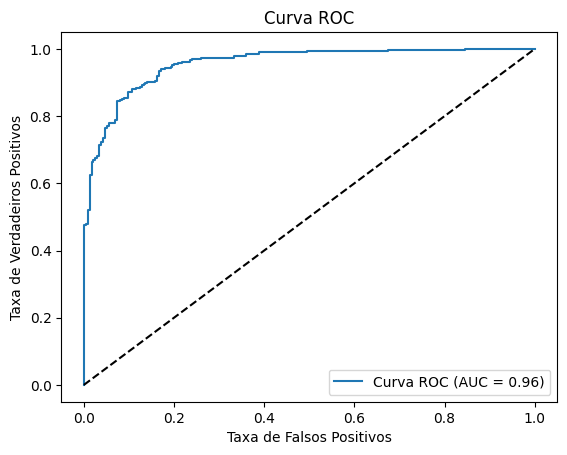

Última camada convolucional: Conv_1
Mapping de classes: {'NORMAL': 0, 'PNEUMONIA': 1}
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_202']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


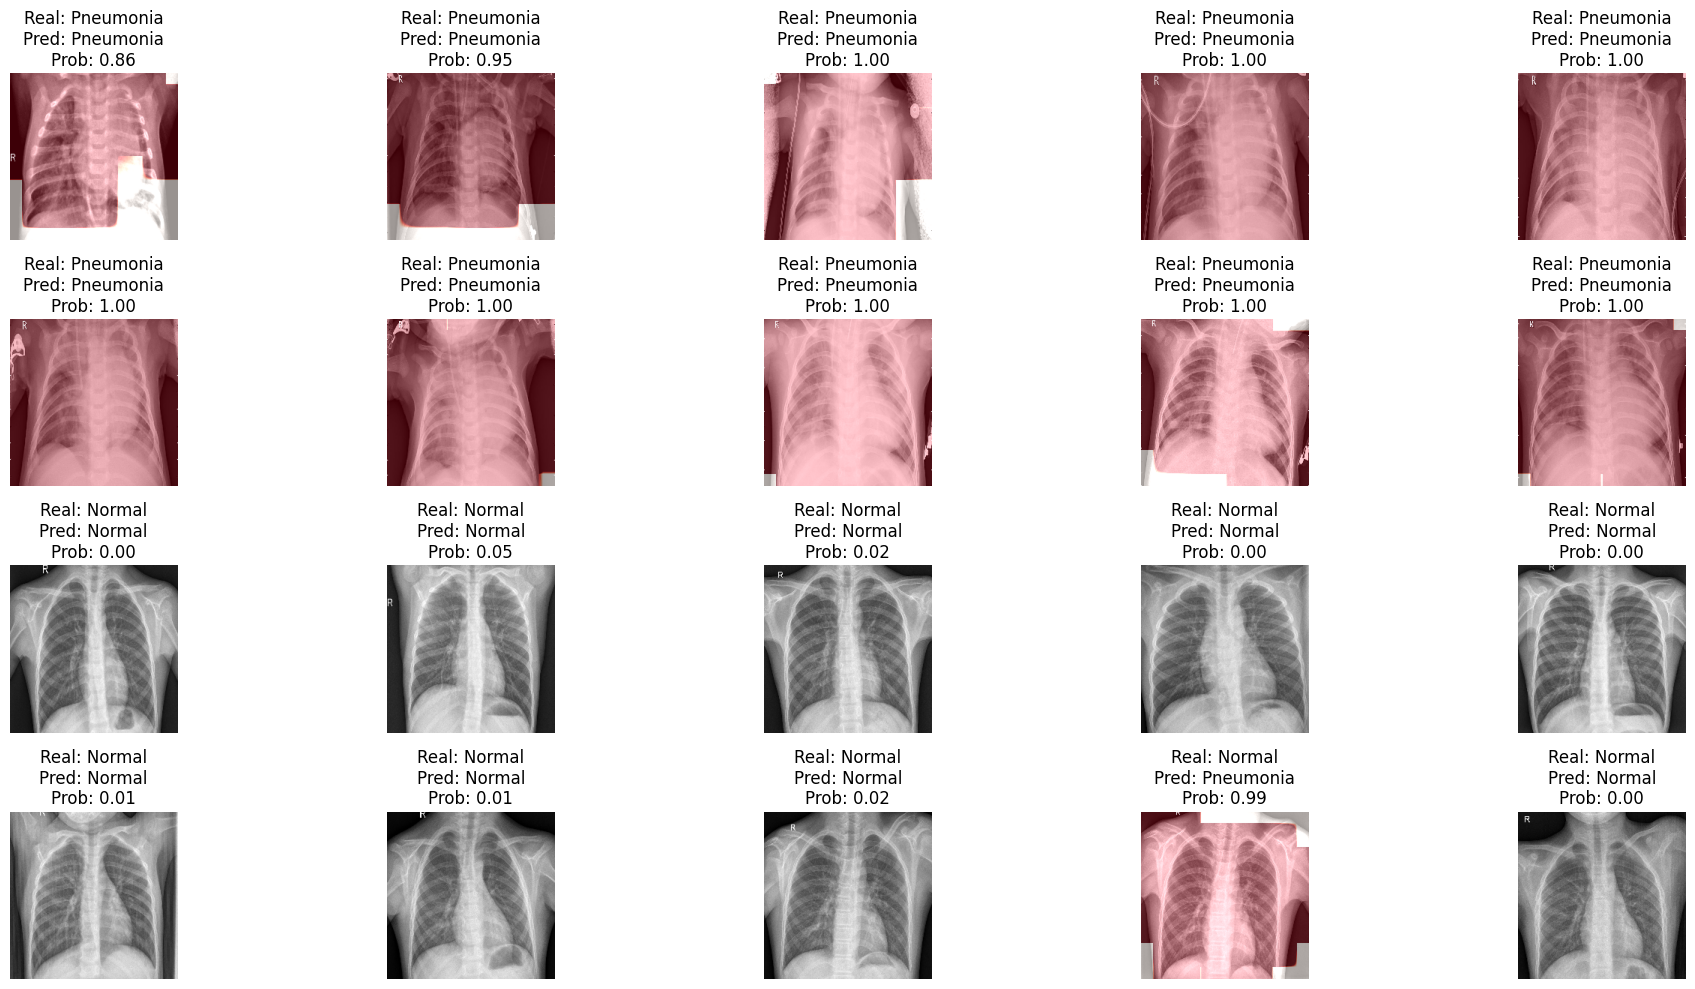

In [ ]:
# Monta o Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import roc_curve, auc

# Caminhos das pastas e do modelo salvo
train_dir = '/content/drive/MyDrive/RV/Projeto/train'
val_dir   = '/content/drive/MyDrive/RV/Projeto/val'
test_dir  = '/content/drive/MyDrive/RV/Projeto/test'
model_path = '/content/drive/MyDrive/RV/Projeto/modelo_pneumoniav2.h5'

# Parâmetros de pré-processamento
image_size = (224, 224)
batch_size = 32

# Geradores de dados
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

print("Mapping das classes:", train_generator.class_indices)

#############################################
# Função para criar o modelo com MobileNetV2
#############################################
def build_model(image_size):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(image_size[0], image_size[1], 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False  # congela o base para treinamento inicial

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.models.Model(inputs=base_model.input, outputs=output)
    return model, base_model

#############################################
# Carrega o modelo salvo ou treina um novo
#############################################
if os.path.exists(model_path):
    model = tf.keras.models.load_model(model_path)
    print("Modelo carregado de", model_path)
else:
    # Cria o modelo
    model, base_model = build_model(image_size)
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision()])
    model.summary()

    #############################################
    # Treinamento inicial
    #############################################
    epochs_initial = 10  # aumente esse valor conforme sua necessidade
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs_initial
    )

    #############################################
    # Fine-tuning: descongela as últimas 20 camadas do base_model
    #############################################
    base_model.trainable = True
    # Congela todas as camadas, exceto as últimas 20
    for layer in base_model.layers[:-20]:
         layer.trainable = False

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision()])

    fine_tune_epochs = 10  # aumente esse valor conforme necessário
    history_fine = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=fine_tune_epochs
    )

    # Salva o modelo para usos futuros
    model.save(model_path)
    print("Modelo salvo em", model_path)

#############################################
# Avaliação no conjunto de teste e métricas
#############################################
test_loss, test_acc, test_precision = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")

# Gera predições no conjunto de teste
test_generator.reset()
preds = model.predict(test_generator)
preds_binary = (preds > 0.5).astype(int).reshape(-1)
true_labels = test_generator.classes

#############################################
# Cálculo e plot da Curva ROC
#############################################
fpr, tpr, thresholds = roc_curve(true_labels, preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

#############################################
# Grad-CAM para segmentação das regiões de pneumonia
#############################################
def get_last_conv_layer(model):
    # Procura pela última camada convolucional
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("Nenhuma camada convolucional encontrada no modelo.")

# Tenta identificar a última camada convolucional do bloco base (no caso do MobileNetV2)
try:
    last_conv_layer_name = get_last_conv_layer(model.get_layer('mobilenetv2_1.00_224'))
except Exception as e:
    last_conv_layer_name = get_last_conv_layer(model)
print("Última camada convolucional:", last_conv_layer_name)

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs * pooled_grads
    heatmap = tf.reduce_sum(heatmap, axis=-1)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + tf.keras.backend.epsilon())
    return heatmap.numpy()

def overlay_heatmap(heatmap, img, alpha=0.6, colormap=plt.cm.Reds):
    # Redimensiona o heatmap para o tamanho da imagem
    heatmap = np.uint8(255 * heatmap)
    heatmap = tf.image.resize(np.expand_dims(heatmap, axis=-1), (img.shape[0], img.shape[1])).numpy()
    heatmap = np.squeeze(heatmap)
    # Aplica o colormap (usando Reds para maior contraste)
    heatmap_color = colormap(heatmap)
    heatmap_color = np.uint8(255 * heatmap_color[:, :, :3])
    # Sobrepõe o heatmap à imagem original com maior transparência (alpha)
    superimposed_img = heatmap_color * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255)
    return np.uint8(superimposed_img)

#############################################
# Visualização: 10 imagens de pneumonia e 10 de normal
#############################################
print("Mapping de classes:", test_generator.class_indices)

# Seleciona índices para cada classe
pneumonia_indices = [i for i, label in enumerate(test_generator.classes) if label == 1][:10]
normal_indices    = [i for i, label in enumerate(test_generator.classes) if label == 0][:10]
selected_indices  = pneumonia_indices + normal_indices

plt.figure(figsize=(20, 10))
for i, idx in enumerate(selected_indices):
    # Obtém o caminho da imagem
    img_path = os.path.join(test_dir, test_generator.filenames[idx])
    img = load_img(img_path, target_size=image_size)
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0) / 255.0  # normaliza

    # Faz a predição para a imagem
    pred_prob = model.predict(img_array_expanded)[0][0]
    pred_label = "Pneumonia" if pred_prob > 0.5 else "Normal"
    true_label = "Pneumonia" if test_generator.classes[idx] == 1 else "Normal"

    # Se for pneumonia, gera o heatmap e sobrepõe à imagem
    if pred_label == "Pneumonia":
        heatmap = make_gradcam_heatmap(img_array_expanded, model, last_conv_layer_name)
        original_img = img_to_array(load_img(img_path, target_size=image_size))
        display_img = overlay_heatmap(heatmap, original_img, alpha=0.6, colormap=plt.cm.Reds)
    else:
        display_img = img_to_array(load_img(img_path, target_size=image_size))

    plt.subplot(4, 5, i + 1)
    plt.imshow(display_img.astype('uint8'))
    plt.title(f"Real: {true_label}\nPred: {pred_label}\nProb: {pred_prob:.2f}")
    plt.axis('off')
plt.tight_layout()
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 5236 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Mapping das classes: {'NORMAL': 0, 'PNEUMONIA': 1}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Modelo carregado de /content/drive/MyDrive/RV/Projeto/modelo_pneumoniav5.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8516 - loss: 0.4954 - precision_1: 0.5023
Test Loss: 0.3460
Test Accuracy: 0.8990
Test Precision: 0.8865
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step


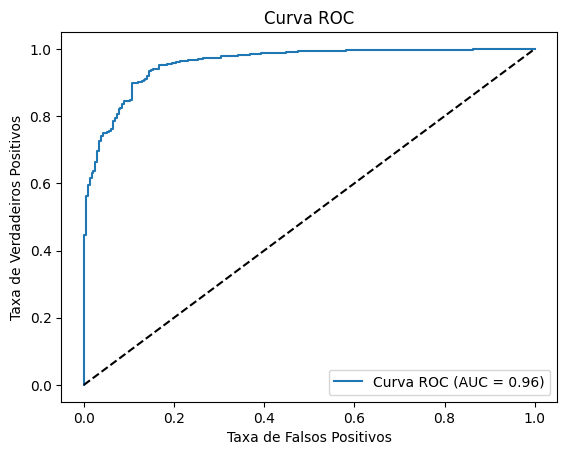

Última camada convolucional: Conv_1
Mapping de classes: {'NORMAL': 0, 'PNEUMONIA': 1}
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


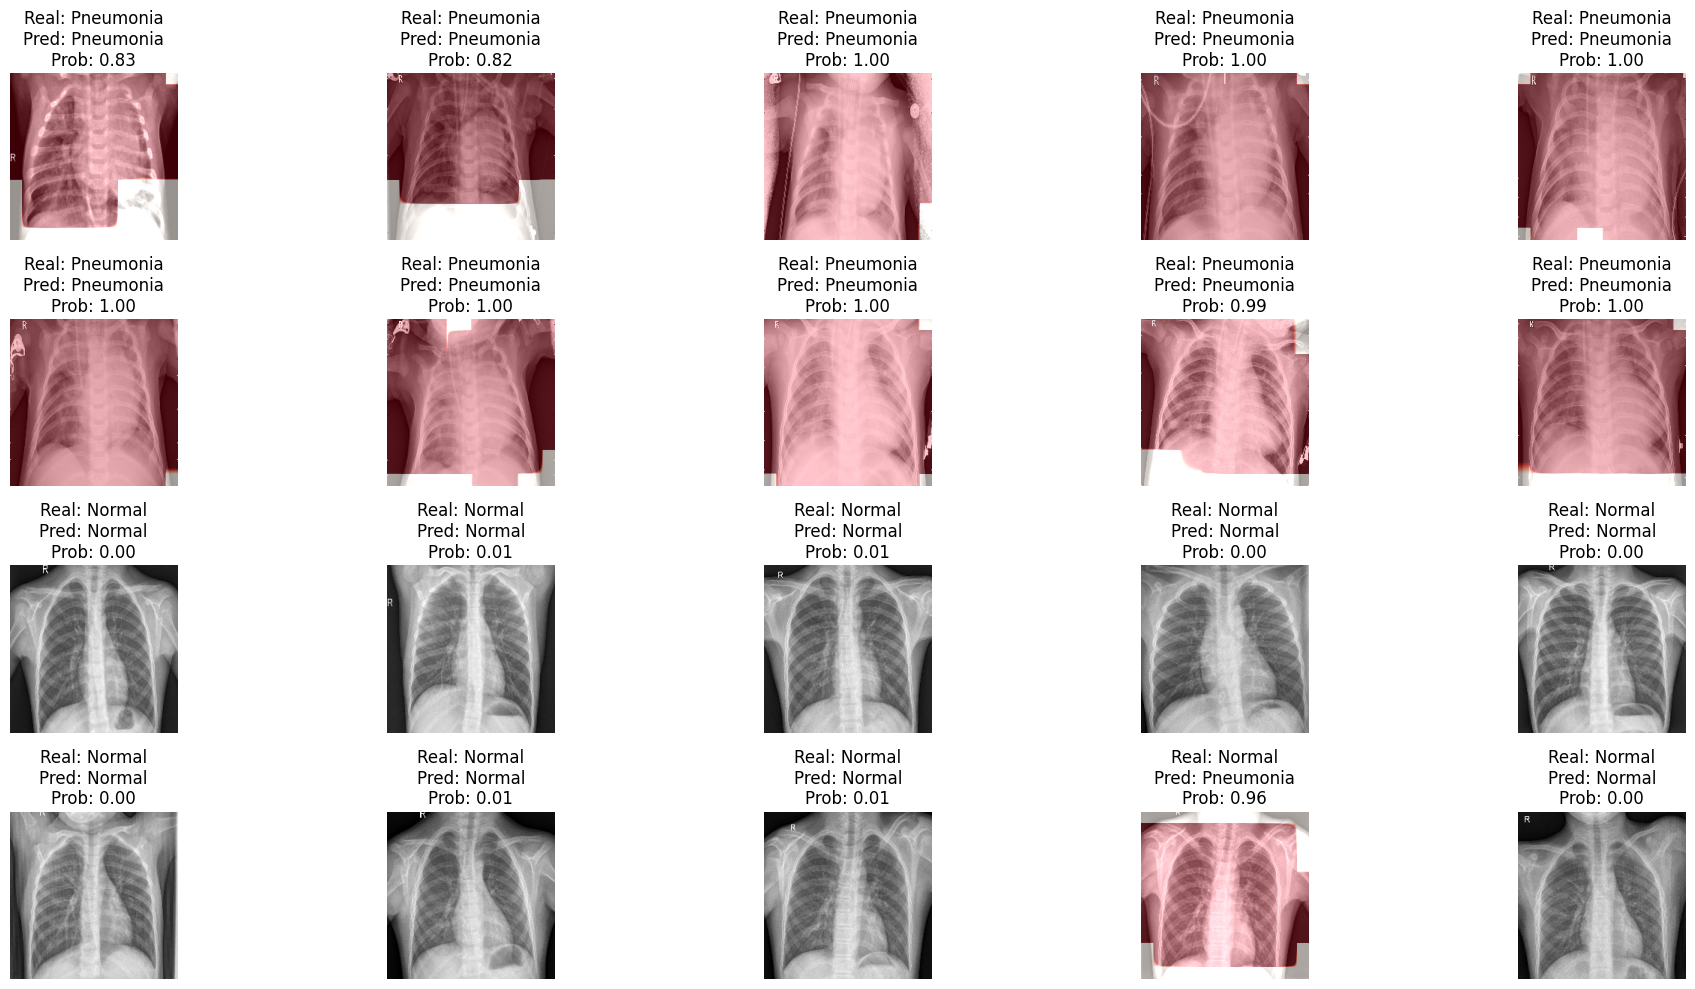

In [2]:
# Monta o Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import roc_curve, auc

# Caminhos das pastas e do modelo salvo
train_dir = '/content/drive/MyDrive/RV/Projeto/train'
val_dir   = '/content/drive/MyDrive/RV/Projeto/val'
test_dir  = '/content/drive/MyDrive/RV/Projeto/test'
model_path = '/content/drive/MyDrive/RV/Projeto/modelo_pneumoniav5.h5'

# Parâmetros de pré-processamento
image_size = (224, 224)
batch_size = 32

# Geradores de dados
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

print("Mapping das classes:", train_generator.class_indices)

#############################################
# Função para criar o modelo com MobileNetV2
#############################################
def build_model(image_size):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(image_size[0], image_size[1], 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False  # congela o base para treinamento inicial

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.models.Model(inputs=base_model.input, outputs=output)
    return model, base_model

#############################################
# Carrega o modelo salvo ou treina um novo
#############################################
if os.path.exists(model_path):
    model = tf.keras.models.load_model(model_path)
    print("Modelo carregado de", model_path)
else:
    # Cria o modelo
    model, base_model = build_model(image_size)
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision()])
    model.summary()

    #############################################
    # Treinamento inicial
    #############################################
    epochs_initial = 15  # aumente esse valor conforme sua necessidade
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs_initial
    )

    #############################################
    # Fine-tuning: descongela as últimas 20 camadas do base_model
    #############################################
    base_model.trainable = True
    # Congela todas as camadas, exceto as últimas 20
    for layer in base_model.layers[:-20]:
         layer.trainable = False

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision()])

    fine_tune_epochs = 15  # aumente esse valor conforme necessário
    history_fine = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=fine_tune_epochs
    )

    # Salva o modelo para usos futuros
    model.save(model_path)
    print("Modelo salvo em", model_path)

#############################################
# Avaliação no conjunto de teste e métricas
#############################################
test_loss, test_acc, test_precision = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")

# Gera predições no conjunto de teste
test_generator.reset()
preds = model.predict(test_generator)
preds_binary = (preds > 0.5).astype(int).reshape(-1)
true_labels = test_generator.classes

#############################################
# Cálculo e plot da Curva ROC
#############################################
fpr, tpr, thresholds = roc_curve(true_labels, preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

#############################################
# Grad-CAM para segmentação das regiões de pneumonia
#############################################
def get_last_conv_layer(model):
    # Procura pela última camada convolucional
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("Nenhuma camada convolucional encontrada no modelo.")

# Tenta identificar a última camada convolucional do bloco base (no caso do MobileNetV2)
try:
    last_conv_layer_name = get_last_conv_layer(model.get_layer('mobilenetv2_1.00_224'))
except Exception as e:
    last_conv_layer_name = get_last_conv_layer(model)
print("Última camada convolucional:", last_conv_layer_name)

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs * pooled_grads
    heatmap = tf.reduce_sum(heatmap, axis=-1)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + tf.keras.backend.epsilon())
    return heatmap.numpy()

def overlay_heatmap(heatmap, img, alpha=0.6, colormap=plt.cm.Reds):
    # Redimensiona o heatmap para o tamanho da imagem
    heatmap = np.uint8(255 * heatmap)
    heatmap = tf.image.resize(np.expand_dims(heatmap, axis=-1), (img.shape[0], img.shape[1])).numpy()
    heatmap = np.squeeze(heatmap)
    # Aplica o colormap (usando Reds para maior contraste)
    heatmap_color = colormap(heatmap)
    heatmap_color = np.uint8(255 * heatmap_color[:, :, :3])
    # Sobrepõe o heatmap à imagem original com maior transparência (alpha)
    superimposed_img = heatmap_color * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255)
    return np.uint8(superimposed_img)

#############################################
# Visualização: 10 imagens de pneumonia e 10 de normal
#############################################
print("Mapping de classes:", test_generator.class_indices)

# Seleciona índices para cada classe
pneumonia_indices = [i for i, label in enumerate(test_generator.classes) if label == 1][:10]
normal_indices    = [i for i, label in enumerate(test_generator.classes) if label == 0][:10]
selected_indices  = pneumonia_indices + normal_indices

plt.figure(figsize=(20, 10))
for i, idx in enumerate(selected_indices):
    # Obtém o caminho da imagem
    img_path = os.path.join(test_dir, test_generator.filenames[idx])
    img = load_img(img_path, target_size=image_size)
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0) / 255.0  # normaliza

    # Faz a predição para a imagem
    pred_prob = model.predict(img_array_expanded)[0][0]
    pred_label = "Pneumonia" if pred_prob > 0.5 else "Normal"
    true_label = "Pneumonia" if test_generator.classes[idx] == 1 else "Normal"

    # Se for pneumonia, gera o heatmap e sobrepõe à imagem
    if pred_label == "Pneumonia":
        heatmap = make_gradcam_heatmap(img_array_expanded, model, last_conv_layer_name)
        original_img = img_to_array(load_img(img_path, target_size=image_size))
        display_img = overlay_heatmap(heatmap, original_img, alpha=0.6, colormap=plt.cm.Reds)
    else:
        display_img = img_to_array(load_img(img_path, target_size=image_size))

    plt.subplot(4, 5, i + 1)
    plt.imshow(display_img.astype('uint8'))
    plt.title(f"Real: {true_label}\nPred: {pred_label}\nProb: {pred_prob:.2f}")
    plt.axis('off')
plt.tight_layout()
plt.show()
